# Trabajo práctico 1: Bayes Ingenuo
En el presente trabajo práctico se introduce la implementación de redes
bayesianas. El trabajo practico consta de 120 puntos, donde 20 son extra
## Integrantes
- Marco Ferraro

In [43]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transformst
import torchvision.transforms as transforms

In [44]:
# Set default tensor type to CUDA if available
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU...")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Implementación de la clasiﬁcación multiclase de imágenes con Bayes ingenuo usando histogramas

Para el presente ejercicio, se implementará la clasiﬁcación de imagenes
naturales con K = 10 clases. La Figura 1 muestra algunas observaciones
del conjunto de datos. El objetivo de su equipo de desarrollo es utilizar el teorema de Bayes para construir un modelo conocido como Bayes
ingenuo, el cual permita estimar la clase a la que pertenece una nueva
observación



### Carga de datos Cifar-10

Para la carga de datos se utilizó la librería cifar10, la cual contiene un conjunto de datos de 50,000 imágenes de 32x32 pixeles en 10 clases diferentes. Se utilizará en escalado de grises para simplificar el problema.

In [45]:
"""
    Carga el conjunto de datos CIFAR-10, convierte las imágenes a escala de grises y las agrupa en un tensor.

    Esta función descarga el conjunto de datos CIFAR-10, aplica una transformación para convertir las imágenes
    a escala de grises y luego agrupa todas las imágenes en un tensor único. También prepara un tensor con las
    etiquetas correspondientes a cada imagen.

    Parámetros:
    - is_train (bool, opcional): Un booleano que indica si se deben cargar los datos de entrenamiento (True) o
      los datos de prueba (False). Por defecto es True.

    Retorna:
    - cifar_trainset_tensor (Tensor): Un tensor que contiene todas las imágenes del conjunto de datos CIFAR-10
      convertidas a escala de grises y redondeadas a valores enteros en el rango de 0 a 255. Las imágenes están
      agrupadas en un tensor único a lo largo de la dimensión del lote.
    - cifar_labels (Tensor): Un tensor que contiene las etiquetas correspondientes a cada imagen en el tensor
      de imágenes.
"""


def load_cifar10_dataset(is_train=True):
  # Define a transformation to convert images to grayscale
  transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
  ])
  cifar_trainset = datasets.CIFAR10(
      root='./data', train=is_train, download=True, transform=transforms_1)

  # Initialize an empty list to store batches
  all_data = []
  train_loader = torch.utils.data.DataLoader(
      cifar_trainset, batch_size=64, shuffle=True)
  # Iterate over the train_loader to fetch all batches
  for batch in train_loader:
      images, _ = batch  # Extract images from the batch
      all_data.append(images)

  # Concatenate all batches into a single tensor along the batch dimension
  cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
  cifar_labels = torch.tensor(cifar_trainset.targets)
  print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
  print("cifar_labels ", cifar_labels.shape)
  return (cifar_trainset_tensor, cifar_labels)


train_tensor, train_labels = load_cifar10_dataset(is_train=True)

train_tensor[1][0]

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


tensor([[85., 84., 85.,  ..., 79., 79., 78.],
        [84., 83., 84.,  ..., 78., 78., 77.],
        [84., 83., 83.,  ..., 77., 77., 76.],
        ...,
        [88., 83., 78.,  ..., 89., 96., 96.],
        [82., 81., 81.,  ..., 84., 91., 91.],
        [86., 83., 80.,  ..., 80., 89., 94.]])

In [46]:
train_tensor.shape

torch.Size([50000, 1, 32, 32])

In [47]:
train_labels.shape

torch.Size([50000])

Graficamos una imagen para visualizar y comprender el dataset. 

torch.Size([32, 32])


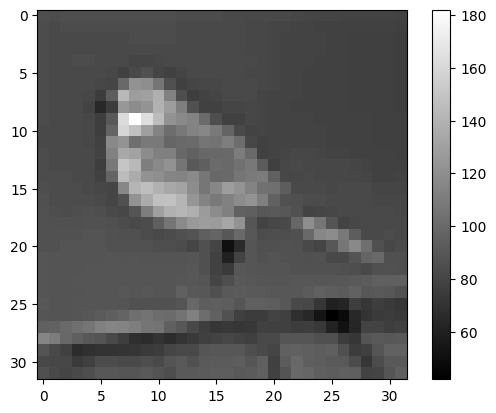

In [48]:
import matplotlib.pyplot as plt

# Asumiendo que train_tensor[1][0] es tu tensor de imagen en escala de grises
image_tensor = train_tensor[1][0]

print(image_tensor.shape)

# Verifica si el tensor está en un dispositivo CUDA y muévelo a CPU
if image_tensor.is_cuda:
    image_tensor = image_tensor.cpu()

# Convierte el tensor a un arreglo de numpy
image_numpy = image_tensor.numpy()

# Dado que es en escala de grises, elimina la dimensión del canal si existe
if image_tensor.dim() > 2:
    image_numpy = image_numpy.squeeze(0)

# Grafica la imagen
plt.imshow(image_numpy, cmap='gray')
plt.colorbar()
plt.show()

In [49]:
image_tensor = train_tensor
image_labels = train_labels

### Caluclo a priori p(t) para las clases

Implemente el cálculo de las probabilidades a priori p (t)
para las K = 10 clases en el conjunto de datos de entrenamiento en
la función calcular_probabilidad_priori. Realice tal calculo dentro de la
funcion train_model.

In [50]:
import torch

"""
Calcula las probabilidades a priori de etiquetas únicas en un conjunto de datos.

Args:
    labels (list o torch.Tensor): Etiquetas para calcular las probabilidades.

Returns:
    tuple (torch.Tensor, torch.Tensor): Probabilidades de cada etiqueta y etiquetas únicas.
"""


def calculate_priori_p_t(labels):
    # Convertir labels a un tensor si aún no lo es
    labels_tensor = torch.tensor(labels) if not isinstance(
        labels, torch.Tensor) else labels

    # Contar las ocurrencias de cada etiqueta
    label_counts = labels_tensor.bincount()

    # Calcular probabilidades dividiendo por el número total de etiquetas
    probabilities = label_counts.float() / labels_tensor.size(0)

    # Generar un tensor de etiquetas únicas ordenadas
    unique_labels = torch.arange(label_counts.size(0))

    # Filtrar etiquetas con conteo cero
    nonzero_indices = label_counts.nonzero().squeeze()
    probabilities = probabilities[nonzero_indices]
    unique_labels = unique_labels[nonzero_indices]

    return probabilities, unique_labels


# Ejemplo de uso de la función
# Asegúrate de definir 'labels' antes de llamar a la función
probabilities, unique_labels = calculate_priori_p_t(train_labels)

print("Probabilities:", probabilities)
print("Unique labels:", unique_labels)
print("Sum of probabilities:", probabilities.sum())
print("Shape of probabilities:", probabilities.shape)

Probabilities: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Sum of probabilities: tensor(1.0000)
Shape of probabilities: torch.Size([10])


Vemos que por defecto, todas las clases tienen la misma probabilidad a priori. Esto significa que estan balanceadas. Esto va a ser modificado en la seccion de entrenamiento.

In [51]:
import torch


# Prueba con etiquetas consecutivas
consecutive_labels = torch.tensor([0, 1, 1, 2, 2, 2])
consecutive_probabilities, consecutive_unique_labels = calculate_priori_p_t(
    consecutive_labels)

assert torch.allclose(consecutive_probabilities, torch.tensor(
    [1/6, 2/6, 3/6])), "Probabilities do not match"
assert torch.equal(consecutive_unique_labels, torch.tensor(
    [0, 1, 2])), "Unique labels do not match"

# Prueba con etiquetas no consecutivas
non_consecutive_labels = torch.tensor([0, 0, 2, 2, 2, 5, 5, 5, 5])
non_consecutive_probabilities, non_consecutive_unique_labels = calculate_priori_p_t(
    non_consecutive_labels)

assert torch.allclose(non_consecutive_probabilities, torch.tensor(
    [2/9, 3/9, 4/9])), "Probabilities do not match"
assert torch.equal(non_consecutive_unique_labels, torch.tensor(
    [0, 2, 5])), "Unique labels do not match"

print("All tests passed successfully.")

All tests passed successfully.


In [52]:
def calculate_marginal_probabilities(data, dim=0):
    # Calculate the marginal probabilities
    marginal_probabilities = data[dim].sum() / data.sum()
    return marginal_probabilities

In [53]:
Mock_data = torch.Tensor([[20.0, 70.0, 80.0, 10.0], [40.0, 10.0, 30.0, 5.0]])

print(calculate_marginal_probabilities(Mock_data, dim=0))
print(calculate_marginal_probabilities(Mock_data, dim=1))


tensor(0.6792)
tensor(0.3208)


In [54]:
def calculate_conditional_probabilities(data):
    # Calculate the conditional probabilities
    n_classes = data.shape[0]

    p_tensor = torch.zeros(data.shape)

    for i in range(n_classes):
        row_sum = data[i].sum()
        p_tensor[i] = data[i] / row_sum

    return p_tensor

p_tensor = calculate_conditional_probabilities(Mock_data)

print("Probabilities for class 0: ", p_tensor[0])
print("Probabilities for class 1: ", p_tensor[1])


Probabilities for class 0:  tensor([0.1111, 0.3889, 0.4444, 0.0556])
Probabilities for class 1:  tensor([0.4706, 0.1176, 0.3529, 0.0588])


In [55]:
import torch


def calculate_pixel_probability(train_data, train_labels, num_classes):
    # D: número de píxeles en una imagen (ancho x alto)
    # Z: número de posibles valores de intensidad (2 para blanco y negro)
    # K: número de clases
    # asumiendo que train_data es [N, H, W]
    D = train_data.shape[1] * train_data.shape[2]
    Z = 256  # blanco y negro
    K = num_classes

    # Inicializar el tensor de probabilidades con ceros
    pixel_probabilities = torch.zeros(D, Z, K)

    for class_id in range(K):
        # Filtrar imágenes por clase
        class_indices = (train_labels == class_id).nonzero().squeeze()
        class_images = train_data[class_indices]

        # Aplanar las imágenes de la clase actual [num_images, D]
        class_images_flattened = class_images.view(class_images.shape[0], D)

        # Calcular la frecuencia de cada valor de intensidad para cada píxel
        for pixel_idx in range(D):
            pixel_values = class_images_flattened[:, pixel_idx]
            for intensity in range(Z):
                # Contar cuántas veces aparece cada intensidad en el píxel actual
                intensity_count = (pixel_values == intensity).sum().item()
                # Calcular la probabilidad y almacenarla
                pixel_probabilities[pixel_idx, intensity,
                                    class_id] = intensity_count / len(class_indices)

    return pixel_probabilities


# Parámetros para generar los datos de ejemplo

# Parámetros para generar los datos de ejemplo
num_images = 10000  # Número total de imágenes
image_height = 32  # Altura de las imágenes (H)
image_width = 32  # Anchura de las imágenes (W)
num_classes = 10  # Número de clases (K)

# Generar datos de entrenamiento de ejemplo
# Las imágenes son en blanco y negro, por lo que los valores de los píxeles serán 0 o 1
# Para simplificar, se generan imágenes aleatorias
train_data = torch.randint(
    0, 256, (num_images, image_height, image_width), dtype=torch.float32)

# Generar etiquetas de ejemplo
# Las etiquetas son números enteros en el rango [0, num_classes-1]
train_labels = torch.randint(0, num_classes, (num_images,), dtype=torch.long)

# Calcular las probabilidades de los píxeles
pixel_probabilities = calculate_pixel_probability(
    train_data, train_labels, num_classes)

# Debería ser [D, 2, K], donde D es el número de píxeles en una imagen
print(pixel_probabilities.shape)

torch.Size([1024, 256, 10])


In [56]:
print(pixel_probabilities[0][0][0])

tensor(0.0030)


In [57]:
import torch


def calculate_pixel_probability(train_data, train_labels, num_classes):
    # D: número de píxeles en una imagen (ancho x alto)
    # Z: número de posibles valores de intensidad (255 para blanco y negro)
    # K: número de clases
    D = train_data.shape[1] * train_data.shape[2]
    Z = 256  # blanco y negro, incluyendo todos los valores de 0 a 255
    K = num_classes

    # Inicializar el tensor de probabilidades con ceros
    pixel_probabilities = torch.zeros(D, Z, K)

    # Convertir train_data a long para usarlo en indexación
    train_data = train_data.long()

    # Aplanar las imágenes [num_images, D]
    flattened_images = train_data.view(-1, D)

    for class_id in range(K):
        # Filtrar imágenes por clase
        class_indices = (train_labels == class_id).nonzero().squeeze()
        class_images_flattened = flattened_images[class_indices]

        # Usar bincount para contar frecuencias de cada intensidad de píxel en todas las imágenes de la clase
        # Se necesita un tensor 2D para los índices: uno para los píxeles y otro para las imágenes
        indices = class_images_flattened + torch.arange(D) * Z
        indices = indices.view(-1)  # Convertir a 1D para bincount
        counts = torch.bincount(indices, minlength=Z*D).view(D, Z)

        # Normalizar las cuentas para obtener probabilidades
        pixel_probabilities[:, :, class_id] = counts.float(
        ) / counts.sum(dim=1, keepdim=True)

    return pixel_probabilities


num_images = 10000  # Número total de imágenes
image_height = 32  # Altura de las imágenes (H)
image_width = 32  # Anchura de las imágenes (W)
num_classes = 10  # Número de clases (K)

# Generar datos de entrenamiento de ejemplo
train_data = torch.randint(
    0, 256, (num_images, image_height, image_width), dtype=torch.float32)

# Generar etiquetas de ejemplo
train_labels = torch.randint(0, num_classes, (num_images,), dtype=torch.long)

print(train_data.shape)

# Calcular las probabilidades de los píxeles
pixel_probabilities = calculate_pixel_probability(
    train_data, train_labels, num_classes)

print(pixel_probabilities.shape)

torch.Size([10000, 32, 32])
torch.Size([1024, 256, 10])


In [58]:
print(pixel_probabilities[0][0][0])

tensor(0.0059)


In [59]:
def calculate_histograms(images, labels, n_classes, n_intensity_levels=256):
    # n_intensity_levels es 256 para imágenes en escala de grises (0-255)
    histograms = torch.zeros(n_classes, n_intensity_levels)

    for class_index in range(n_classes):
        class_images = images[labels == class_index]
        # Aplana las imágenes de la clase y cuenta las frecuencias de cada nivel de intensidad
        flattened_images = class_images.flatten()
        counts = torch.histc(
            flattened_images, bins=n_intensity_levels, min=0, max=255)
        histograms[class_index] = counts

    return histograms

In [60]:
def histograms_to_probabilities(histograms):
    # Normaliza los histogramas para convertirlos en probabilidades
    probabilities = histograms / histograms.sum(dim=1, keepdim=True)
    return probabilities

In [61]:
"""
    Entrena un modelo generando histogramas de densidades de clase a partir de los datos de entrenamiento.

    Esta función calcula las probabilidades a priori de cada clase y las densidades de los datos de entrenamiento
    para cada clase. Luego, aplana las densidades de los datos para simplificar su estructura.

    Args:
    - train_data (Tensor): Un tensor que contiene los datos de entrenamiento. Se espera que tenga la forma
      adecuada para el modelo que se está entrenando.
    - train_labels (Tensor): Un tensor que contiene las etiquetas de los datos de entrenamiento. Cada etiqueta
      debe corresponder a los datos en `train_data`.
    - normalize (bool, opcional): Un booleano que indica si se deben normalizar las densidades de los datos.
      Por defecto es True.

    Returns:
    - dataset_densities (Tensor): Un tensor que contiene las densidades de los datos de entrenamiento
      para cada clase. Las densidades están aplanadas para simplificar su estructura.
    - priori_p_k (Tensor): Un tensor que contiene las probabilidades a priori de cada clase basadas en
      las etiquetas de entrenamiento.
"""

def train_model_histogram(train_data, train_labels, normalize=True):
    priori_p_k, unique_labels = calculate_priori_p_t(train_labels)
    # Reshape the data
    flattened_data = train_data.squeeze(1)
    # Check the new shape of the tensor
    dataset_densities = calculate_pixel_probability(flattened_data, train_labels, num_classes=len(
        unique_labels))

    return dataset_densities, priori_p_k


dataset_densities, priori_p_k = train_model_histogram(train_tensor, train_labels)

print(dataset_densities.shape)
print(dataset_densities[0][0].sum())

torch.Size([1024, 256, 10])
tensor(0.0428)


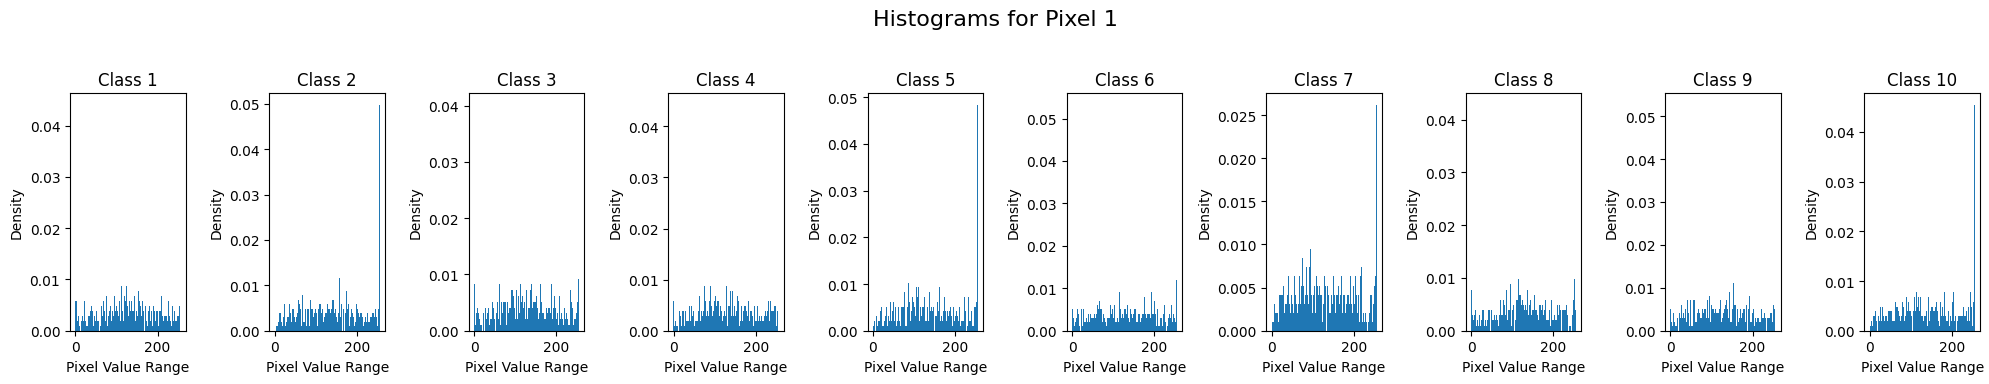

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors

"""
    Grafica histogramas para el número especificado de píxeles de una clase dada.

    Parámetros:
    - dataset_densities: Un tensor con forma [num_classes, 256, num_pixels].
    - class_index: El índice de la clase para la cual se graficarán los histogramas.
    - num_pixels: El número de píxeles para los cuales se graficarán histogramas.
    - bins: El número de contenedores para agrupar los valores de los píxeles.

    Esta función convierte el tensor a un arreglo de numpy si es un tensor de PyTorch, extrae las densidades
    para la clase especificada, calcula los bordes y anchos de los contenedores para la agregación y grafica
    histogramas para el número especificado de píxeles. Cada histograma muestra la densidad de los valores de
    píxeles dentro de rangos específicos para un píxel dado.
"""


import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors


def plot_pixel_densities(dataset_densities, pixel_index=0, bins=16):
    # Convertir el tensor a un arreglo numpy si es un tensor de PyTorch
    if isinstance(dataset_densities, torch.Tensor):
        dataset_densities = dataset_densities.numpy()

    # Calculate bin edges and widths for aggregation
    bin_edges = np.linspace(0, 256, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]

    # Graficar histogramas para cada clase
    # dataset_densities.shape[2] is the number of classes
    fig, axs = plt.subplots(1, dataset_densities.shape[2], figsize=(20, 4))
    for i in range(dataset_densities.shape[2]):
        # Extraer las densidades para el píxel y clase especificados
        pixel_densities = dataset_densities[pixel_index, :, i]
        # Agregar densidades de píxeles en contenedores
        binned_densities = np.histogram(
            np.arange(256), bins=bin_edges, weights=pixel_densities)[0]
        axs[i].bar(bin_edges[:-1], binned_densities, width=bin_width)
        axs[i].set_title(f'Class {i+1}')
        axs[i].set_xlabel('Pixel Value Range')
        axs[i].set_ylabel('Density')

    fig.suptitle(f'Histograms for Pixel {pixel_index + 1}', fontsize=16)

    # Ajustar el diseño para hacer espacio para el título
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Ejemplo de uso
# Simulated random tensor for demonstration

plot_pixel_densities(dataset_densities, pixel_index=0, bins=256)

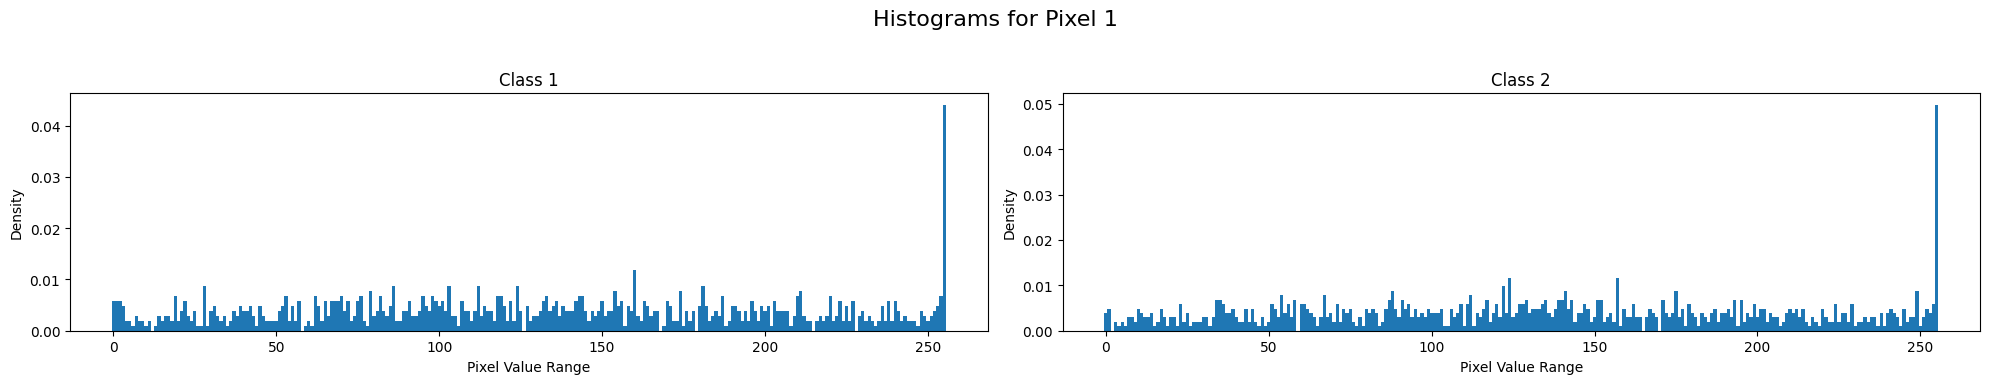

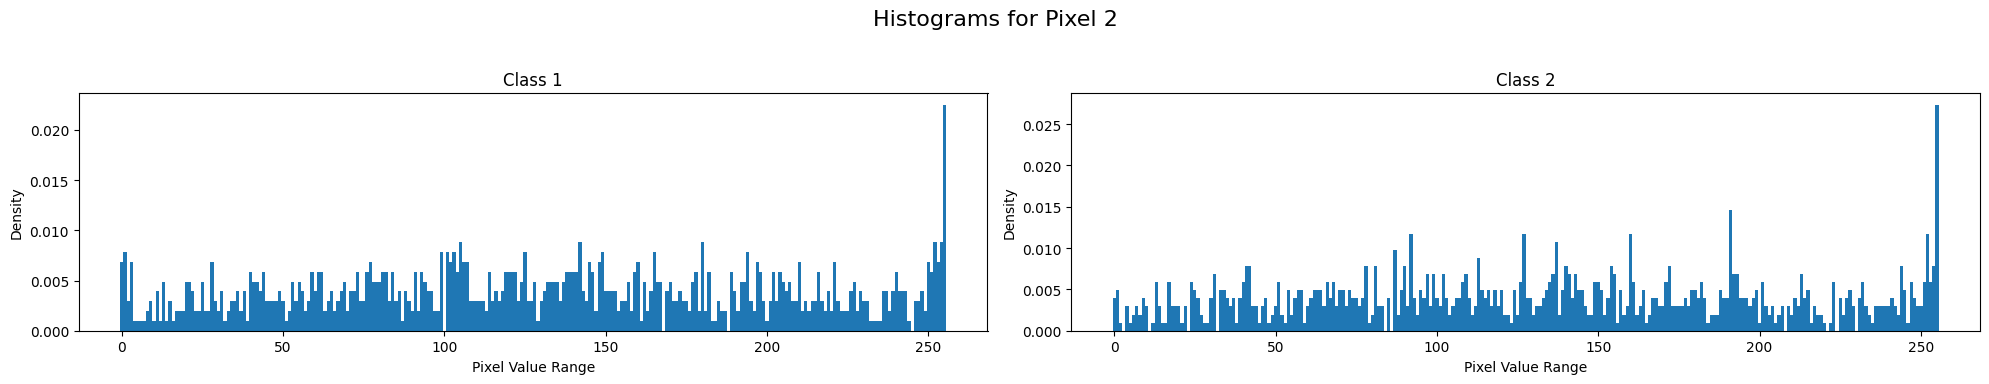

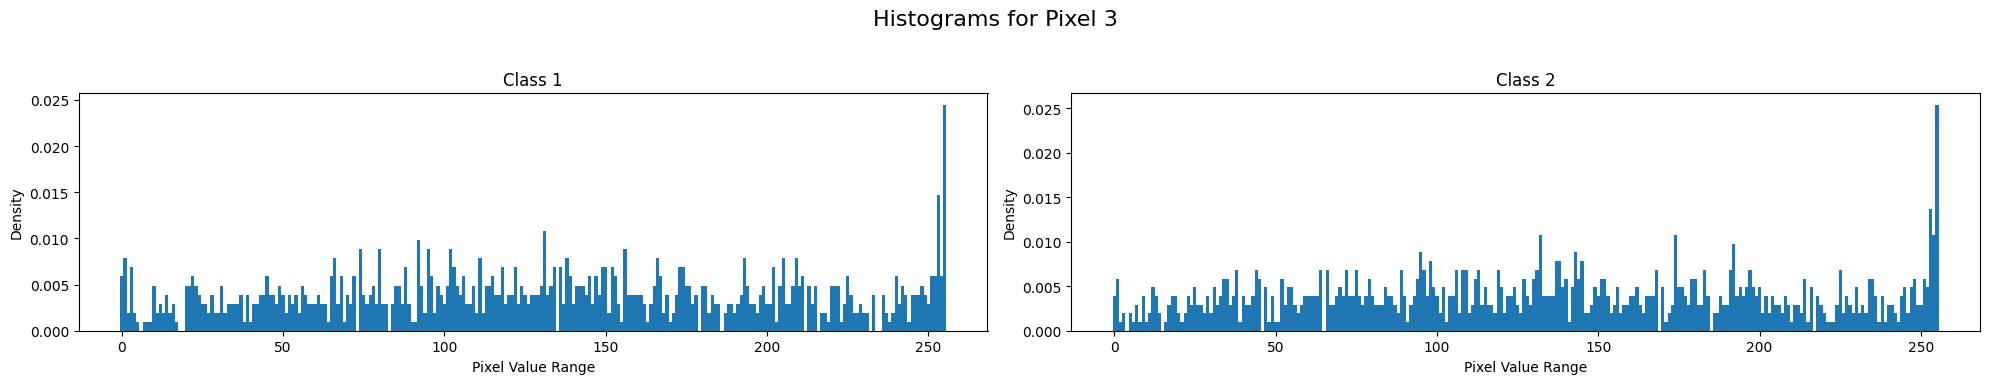

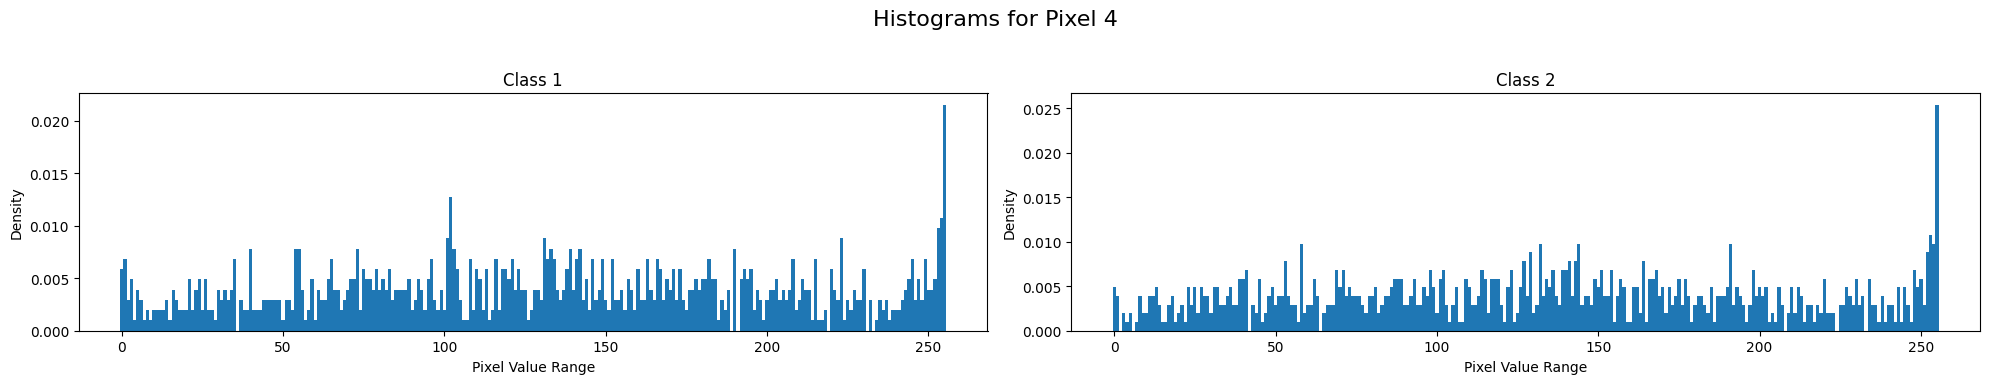

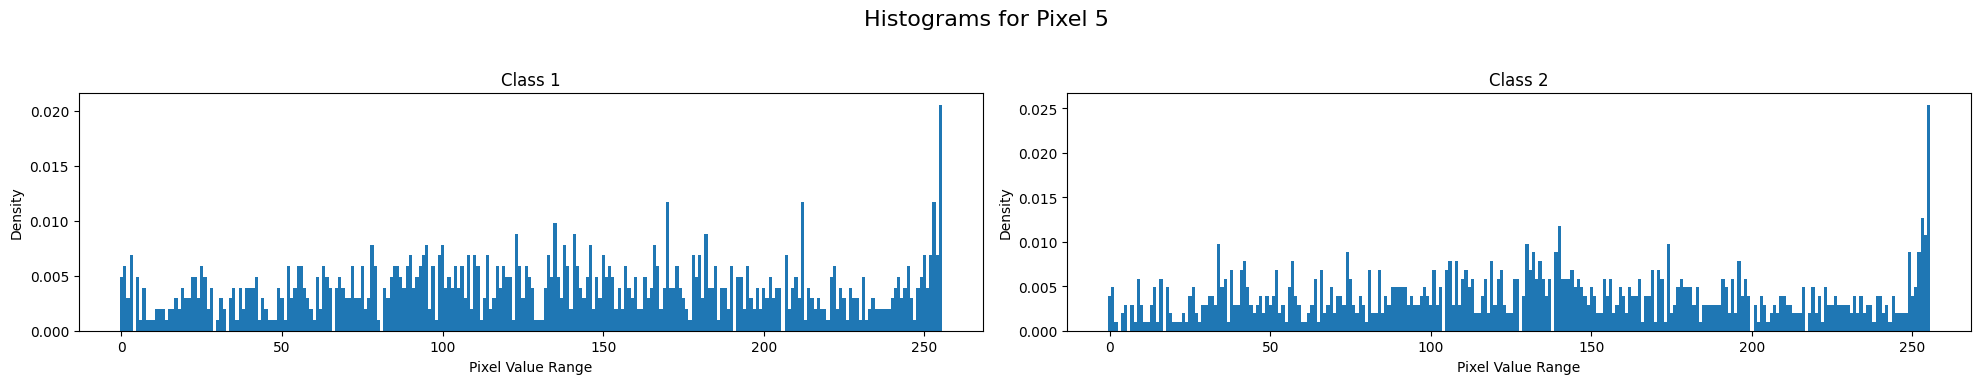

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors


def plot_pixel_densities(dataset_densities, pixel_index=0, bins=16, num_classes_to_plot=2):
    # Convertir el tensor a un arreglo numpy si es un tensor de PyTorch
    if isinstance(dataset_densities, torch.Tensor):
        dataset_densities = dataset_densities.numpy()

    # Calculate bin edges and widths for aggregation
    bin_edges = np.linspace(0, 256, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]

    # Graficar histogramas para el número especificado de clases
    fig, axs = plt.subplots(1, num_classes_to_plot, figsize=(20, 4))
    for i in range(num_classes_to_plot):
        # Extraer las densidades para el píxel y clase especificados
        pixel_densities = dataset_densities[pixel_index, :, i]
        # Agregar densidades de píxeles en contenedores
        binned_densities = np.histogram(
            np.arange(256), bins=bin_edges, weights=pixel_densities)[0]
        axs[i].bar(bin_edges[:-1], binned_densities, width=bin_width)
        axs[i].set_title(f'Class {i+1}')
        axs[i].set_xlabel('Pixel Value Range')
        axs[i].set_ylabel('Density')

    fig.suptitle(f'Histograms for Pixel {pixel_index + 1}', fontsize=16)

    # Ajustar el diseño para hacer espacio para el título
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_pixel_densities(dataset_densities, pixel_index=0,bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=1,bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=2, bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=3, bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=4, bins=256, num_classes_to_plot=2)

In [64]:

import numpy as np


def test_model_histogram(input_image, dataset_densities, priori_p_k):
    # Inicializar la variable de salida

    flattened_input_image = input_image.flatten()
    class_likelihoods = np.zeros(len(priori_p_k))

    for i in range(len(flattened_input_image)):
        pixel_intensity = int(flattened_input_image[i].item())
        for j in range(len(priori_p_k)):
            class_likelihoods[j] += torch.log(dataset_densities[i][pixel_intensity][j]) + torch.log(priori_p_k[j])
            #if class_likelihoods[j] == 0:
            #  class_likelihoods[j] += dataset_densities[i][pixel_intensity][j] * priori_p_k[j]
            #else:
            #  class_likelihoods[j] *= dataset_densities[i][pixel_intensity][j] * priori_p_k[j]
    return class_likelihoods

test_specific_image = train_tensor[1][0]
print(test_specific_image.shape)

likelihood_array = test_model_histogram(test_specific_image, dataset_densities, priori_p_k)
print(train_labels[1].item())

print(np.argmax(likelihood_array))

torch.Size([32, 32])
7
7


In [69]:
def test_model_batch_histogram(test_data, labels, dataset_densities, priori_p_k):
    y_truth = labels
    y_pred = []

    for image in test_data:
        flattened_image = image.flatten()
        likelihood_array = test_model_histogram(flattened_image, dataset_densities, priori_p_k)
        y_pred.append(np.argmax(likelihood_array))

    correct_predictions = np.sum(np.array(y_pred) == np.array(y_truth))
    accuracy = correct_predictions / len(y_truth)

    return accuracy, y_pred, y_truth

In [72]:
test_tensor, test_labels = load_cifar10_dataset(is_train=False)

accuracy, y_pred, y_truth = test_model_batch_histogram(test_tensor, test_labels, dataset_densities, priori_p_k)

print("Accuracy: ", accuracy)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])
Accuracy:  0.14285714285714285
